# Neural FMUs in co simulation (CS) mode
Tutorial by Tobias Thummerer

*Last edit: 03.09.2024*

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

## Introduction
Functional mock-up units (FMUs) can easily be seen as containers for simulation models. 

This example shows how to build a very easy neural FMU by combining a co simulation (CS) FMU and an artificial neural network (ANN).
The goal is, to train the hybrid model based on a very simple simulation model.

## Packages
First, import the packages needed:

In [2]:
# imports
using FMI                       # for importing and simulating FMUs
using FMIFlux                   # for building neural FMUs
using FMIFlux.Flux              # the default machine learning library in Julia
using FMIZoo                    # a collection of demo FMUs
using Plots                     # for plotting some results

import Random                   # for random variables (and random initialization)
Random.seed!(1234)              # makes our program deterministic

Random.TaskLocalRNG()

## Code
Next, start and stop time are set for the simulation, as well as some intermediate time points `tSave` to record simulation results.

In [3]:
tStart = 0.0
tStep = 0.01
tStop = 5.0
tSave = collect(tStart:tStep:tStop)

501-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 4.89
 4.9
 4.91
 4.92
 4.93
 4.94
 4.95
 4.96
 4.97
 4.98
 4.99
 5.0

### Complex FMU (ground truth training data)
First, let's load a model from the *FMIZoo.jl*, an easy pendulum including some friction. We will use that to generate training data.

In [4]:
# let's load the FMU in CS-mode (some FMUs support multiple simulation modes)
fmu_gt = loadFMU("SpringPendulum1D", "Dymola", "2022x"; type=:CS)  

# and print some info
info(fmu_gt)   

#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{fc15d8c4-758b-48e6-b00e-5bf47b8b14e5}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:23Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2


		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Parameters:			7
		16777216 ["mass_s0"]
		16777217 ["mass_v0"]
		16777218 ["fixed.s0"]
		16777219 ["spring.c"]
		16777220 ["spring.s_rel0"]
		16777221 ["mass.m"]
		16777222 ["mass.L"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


Next, some variables to be recorded `vrs` are defined (they are identified by the names that where used during export of the FMU). The FMU is simulated and the results are plotted.

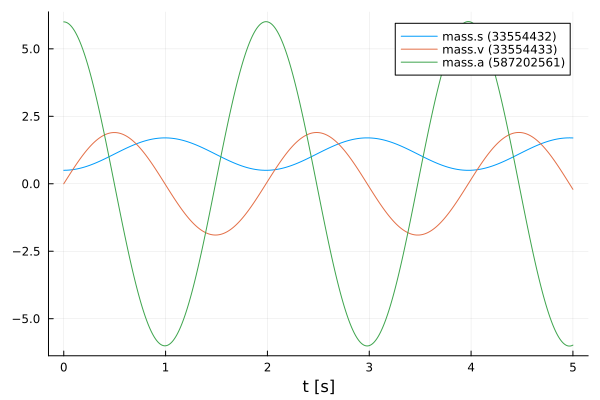

In [5]:
# the initial state we start our simulation with, position (0.5 m) and velocity (0.0 m/s) of the pendulum
x0 = [0.5, 0.0] 

# some variables we are interested in, so let's record them: position, velocity and acceleration
vrs = ["mass.s", "mass.v", "mass.a"]  

# set the start state via parameters 
parameters = Dict("mass_s0" => x0[1], "mass_v0" => x0[2]) 

# simulate the FMU ...
sol_gt = simulate(fmu_gt, (tStart, tStop); recordValues=vrs, saveat=tSave, parameters=parameters)    

# ... and plot it!
plot(sol_gt)                                                                    

After the simulation, specific variables can be extracted. We will use them for the later training - as training data!

In [6]:
vel_gt = getValue(sol_gt, "mass.v")
acc_gt = getValue(sol_gt, "mass.a")

501-element Vector{Float64}:
  6.0
  5.996872980925033
  5.987824566254761
  5.9728274953129645
  5.95187583433241
  5.9249872805026715
  5.892169834645022
  5.853465119227542
  5.808892969264781
  5.75851573503067
  5.702370188387734
  5.640527685538739
  5.573049035471661
  ⋮
 -5.842615646003006
 -5.884869953422783
 -5.921224800662572
 -5.9516502108284985
 -5.976144547672481
 -5.994659284032171
 -6.007174453690571
 -6.013675684067705
 -6.014154196220591
 -6.008606804843264
 -5.997055285530499
 -5.979508813705998

Now, we can release the FMU again - we don't need it anymore.

In [7]:
unloadFMU(fmu_gt)

### Simple FMU
Now, we load an even more simple system, that we use as *core* for our neural FMU: A pendulum *without* friction. Again, we load, simulate and plot the FMU and its results.

#################### Begin information for FMU ####################
	Model name:			SpringPendulumExtForce1D
	FMI-Version:			2.0
	GUID:				{df5ebe46-3c86-42a5-a68a-7d008395a7a3}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:33Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				1
		352321536 ["extForce"]
	Outputs:			2
		335544320 ["accSensor.v", "der(accSensor.flange.s)", "v", "der(speedSensor.flange.s)", "speedSensor.v"]
		335544321 ["der(accSensor.v)", "a", "accSensor.a"]
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Parameters:			6
		16777216 ["mass_s0"]
		16777217 ["fixed.s0"]
		16777218 ["spring.c"]
		16777219 ["spring.s_rel0"]
		16777220 ["mass.m"]
		16777221 ["mass.L"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulumExtForce1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-

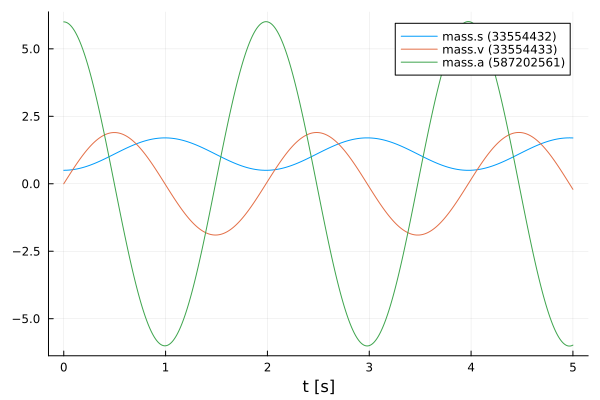

In [8]:
fmu = loadFMU("SpringPendulumExtForce1D", "Dymola", "2022x"; type=:CS)
info(fmu)

# set the start state via parameters 
parameters = Dict("mass_s0" => x0[1], "mass.v" => x0[2])

sol_fmu = simulate(fmu, (tStart, tStop); recordValues=vrs, saveat=tSave, parameters=parameters)
plot(sol_fmu)

### Neural FMU
First, let's check the inputs and outputs of our CS FMU.

In [9]:
# outputs
println("Outputs:")
y_refs = fmu.modelDescription.outputValueReferences 
numOutputs = length(y_refs)
for y_ref in y_refs 
    name = valueReferenceToString(fmu, y_ref)
    println("$(y_ref) -> $(name)")
end

# inputs
println("\nInputs:")
u_refs = fmu.modelDescription.inputValueReferences 
numInputs = length(u_refs)
for u_ref in u_refs 
    name = valueReferenceToString(fmu, u_ref)
    println("$(u_ref) -> $(name)")
end

Outputs:
335544320 -> ["accSensor.v", "der(accSensor.flange.s)", "v", "der(speedSensor.flange.s)", "speedSensor.v"]
335544321 -> ["der(accSensor.v)", "a", "accSensor.a"]

Inputs:
352321536 -> ["extForce"]


Now the fun begins, let's combine the loaded FMU and the ANN! 

In [10]:
net = Chain(u -> fmu(;u_refs=u_refs, u=u, y_refs=y_refs),   # we can use the FMU just like any other neural network layer!
            Dense(numOutputs, 16, tanh),                    # some additional dense layers ...
            Dense(16, 16, tanh),
            Dense(16, numOutputs))

# the neural FMU is constructed by providing the FMU, the net topology, start and stop time
neuralFMU = CS_NeuralFMU(fmu, net, (tStart, tStop));

Before we can check that neural FMU, we need to define a input function, because the neural FMU - as well as the original FMU - has inputs.

In [11]:
function extForce(t)
    return [0.0]
end 

extForce (generic function with 1 method)

Now, we can check how the neural FMU performs before the actual training!

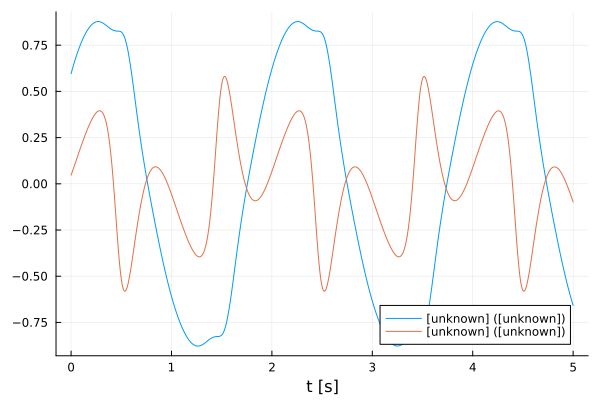

In [12]:
solutionBefore = neuralFMU(extForce, tStep, (tStart, tStop); parameters=parameters)
plot(solutionBefore)

Not that ideal... let's add our ground truth data to compare!

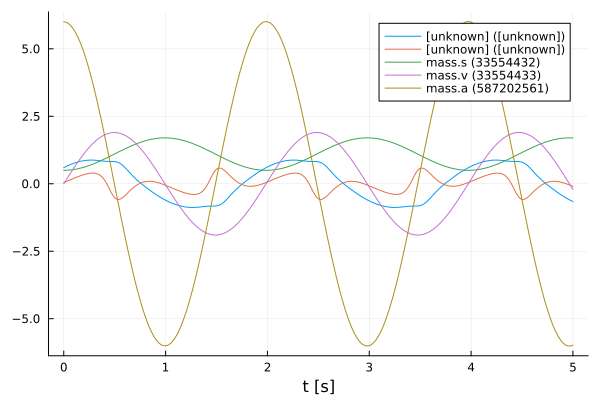

In [13]:
plot!(sol_gt)

Ufff... training seems a good idea here!

### Loss function
Before we can train the neural FMU, we need to define a loss function. We use the common mean-squared-error (MSE) here.

In [14]:
function loss(p)
    # simulate the neural FMU by calling it
    sol_nfmu = neuralFMU(extForce, tStep, (tStart, tStop); parameters=parameters, p=p)

    # we use the second value, because we know that's the acceleration
    acc_nfmu = getValue(sol_nfmu, 2; isIndex=true)
    
    # we could also identify the position state by its name
    #acc_nfmu = getValue(sol_nfmu, "mass.a")
    
    FMIFlux.Losses.mse(acc_gt, acc_nfmu) 
end

loss (generic function with 1 method)

### Callback
Further, we define a simple logging function for our training.

In [15]:
global counter = 0
function callback(p)
    global counter += 1
    if counter % 20 == 1
        lossVal = loss(p[1])
        @info "Loss [$(counter)]: $(round(lossVal, digits=6))"
    end
end

callback (generic function with 1 method)

### Training
For training, we only need to extract the parameters to optimize and pass it to a pre-build train command `FMIFlux.train!`.

In [16]:
optim = Adam()

p = FMIFlux.params(neuralFMU)

FMIFlux.train!(
    loss, 
    neuralFMU,
    Iterators.repeated((), 500), 
    optim; 
    cb=()->callback(p)
) 

[ Info: Loss [1]: 16.874727


[ Info: Loss [21]: 10.452957


[ Info: Loss [41]: 6.017093


[ Info: Loss [61]: 3.327601


[ Info: Loss [81]: 1.87555


[ Info: Loss [101]: 1.162226


[ Info: Loss [121]: 0.818483


[ Info: Loss [141]: 0.625927


[ Info: Loss [161]: 0.487464


[ Info: Loss [181]: 0.373996


[ Info: Loss [201]: 0.28081


[ Info: Loss [221]: 0.207289


[ Info: Loss [241]: 0.151647


[ Info: Loss [261]: 0.110905


[ Info: Loss [281]: 0.081792


[ Info: Loss [301]: 0.061356


[ Info: Loss [321]: 0.047178


[ Info: Loss [341]: 0.037386


[ Info: Loss [361]: 0.030586


[ Info: Loss [381]: 0.025778


[ Info: Loss [401]: 0.02227


[ Info: Loss [421]: 0.019598


[ Info: Loss [441]: 0.017464


[ Info: Loss [461]: 0.015685


[ Info: Loss [481]: 0.014149


## Results
Finally, we can compare the results before and after training, as well as the ground truth data:

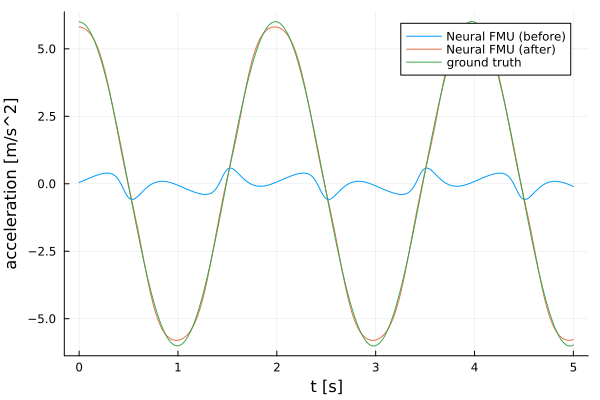

In [17]:
solutionAfter = neuralFMU(extForce, tStep, (tStart, tStop); parameters=parameters)

fig = plot(solutionBefore; valueIndices=2:2, label="Neural FMU (before)", ylabel="acceleration [m/s^2]")
plot!(fig, solutionAfter; valueIndices=2:2, label="Neural FMU (after)")
plot!(fig, tSave, acc_gt; label="ground truth")
fig

Finally, the FMU is unloaded and memory released.

In [18]:
unloadFMU(fmu)

### Source

[1] Tobias Thummerer, Lars Mikelsons and Josef Kircher. 2021. **NeuralFMU: towards structural integration of FMUs into neural networks.** Martin Sjölund, Lena Buffoni, Adrian Pop and Lennart Ochel (Ed.). Proceedings of 14th Modelica Conference 2021, Linköping, Sweden, September 20-24, 2021. Linköping University Electronic Press, Linköping (Linköping Electronic Conference Proceedings ; 181), 297-306. [DOI: 10.3384/ecp21181297](https://doi.org/10.3384/ecp21181297)


## Build information

In [19]:
# check package build information for reproducibility
import Pkg; Pkg.status()

Status `D:\a\FMIFlux.jl\FMIFlux.jl\examples\Project.toml`
  [0c46a032] DifferentialEquations v7.14.0
  [14a09403] FMI v0.14.1
  [fabad875] FMIFlux v0.13.0 `D:\a\FMIFlux.jl\FMIFlux.jl`
  [9fcbc62e] FMIImport v1.0.6
  [724179cf] FMIZoo v1.1.0
  [587475ba] Flux v0.14.19
  [7073ff75] IJulia v1.25.0
⌃ [033835bb] JLD2 v0.4.53
  [b964fa9f] LaTeXStrings v1.3.1
  [f0f68f2c] PlotlyJS v0.18.14
  [91a5bcdd] Plots v1.40.8
  [9a3f8284] Random
Info Packages marked with ⌃ have new versions available and may be upgradable.
